In [1]:
from __future__ import division, print_function, absolute_import

#Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist', one_hot=True)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\train-images-idx3-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\train-labels-idx1-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\t10k-images-idx3-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


In [2]:
#Training Params
learning_rate = 0.001
num_steps = 1000
batch_size = 128

#Network Params
num_input = 784 #MNIST data input (image shape 28*28)
num_classes = 10 #MNIST total classes (0-9 digits)
dropout = 0.25 #Dropout, probability drop a unit (0.75 keep, 0.25 drop)

In [3]:
#Create neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    #Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        #TF estimator input is a dict, in case of multiple dict
        x = x_dict['images']
        
        #MNIST data input is a 1-D vector of 784 features (28*28)
        #Reshape to match picture format [height * width * channel]
        #Tensor input become 4-D [batch size * height * width * channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        #Convolution layer 1 with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, filters=32, kernel_size=5, activation=tf.nn.relu)
        #MaxPooling layer 1 with strides 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, strides=2, pool_size=2)
        
        #Convolution layer 2 with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=3, activation=tf.nn.relu)
        #MaxPooling layer 2 with strides 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, strides=2, pool_size=2)
        
        #Flatten the data to 1-D vector for fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)
        
        #Fully connected layer 1024 output
        fc1 = tf.layers.dense(fc1, 1024)
        #Apply dropout for fully connected (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        
        #Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
    
    return out

In [10]:
#Define the model function (following TF estimator template)
def model_function(features, labels, mode):
    #Build the neural network
    #Because Dropout have different behavior at training and prediction time, we
    #need to create 2 distinct computation graphs that still share the same weights
    logits_train = conv_net(features, n_classes=num_classes, dropout=dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, n_classes=num_classes, dropout=dropout, reuse=True, is_training=False)
    
    #Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits=logits_test)
    
    #If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)
    
    #Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, 
                                                                            labels=tf.argmax(tf.cast(labels, dtype=tf.int32),1)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    #Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=tf.argmax(tf.cast(labels, dtype=tf.int32),1), predictions=pred_classes)
    
    #TF Estimators require to return a estimatorspec, that specify
    #the different ops for training, evaluating
    estim_specs = tf.estimator.EstimatorSpec(mode=mode, 
                                             predictions=pred_classes, 
                                             loss=loss_op, 
                                             train_op=train_op, 
                                             eval_metric_ops={'accuracy': acc_op})
    
    return estim_specs

In [11]:
# Build the estimator
model = tf.estimator.Estimator(model_function)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_master': '', '_model_dir': 'C:\\Users\\STRIKE~1\\AppData\\Local\\Temp\\tmpnv0keo5p', '_is_chief': True, '_tf_random_seed': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021F0C2D2BE0>, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_task_type': 'worker'}


In [12]:
# #Define the input function for training
train_input_function = tf.estimator.inputs.numpy_input_fn(x={'images': mnist.train.images}, 
                                                    y=mnist.train.labels, 
                                                    batch_size=batch_size, 
                                                    num_epochs=None, 
                                                    shuffle=True)

#Train the model
model.train(train_input_function, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpnv0keo5p\model.ckpt.
INFO:tensorflow:loss = 2.313802, step = 1
INFO:tensorflow:global_step/sec: 24.0989
INFO:tensorflow:loss = 0.05558361, step = 101 (4.150 sec)
INFO:tensorflow:global_step/sec: 23.8074
INFO:tensorflow:loss = 0.07769612, step = 201 (4.201 sec)
INFO:tensorflow:global_step/sec: 23.9136
INFO:tensorflow:loss = 0.1255713, step = 301 (4.182 sec)
INFO:tensorflow:global_step/sec: 23.4672
INFO:tensorflow:loss = 0.036192585, step = 401 (4.261 sec)
INFO:tensorflow:global_step/sec: 23.2632
INFO:tensorflow:loss = 0.024948528, step = 501 (4.299 sec)
INFO:tensorflow:global_step/sec: 23.393
INFO:tensorflow:loss = 0.12812209, step = 601 (4.275 sec)
INFO:tensorflow:global_step/sec: 23.595
INFO:tensorflow:loss = 0.10041905, step = 701 (4.238 sec)
INFO:tensorflow:global_step/sec: 24.3596
INFO:tensorflow:loss = 0.08226952, step = 801 (4.105 sec)
INFO:tensorflow:

In [13]:
#Evaluate the model
#Define the input function for evaluating
eval_input_function = tf.estimator.inputs.numpy_input_fn(x={'images': mnist.test.images}, 
                                                         y=mnist.test.labels, 
                                                         batch_size=batch_size, 
                                                         shuffle=False)
#Use the estimator 'evaluate method'
model.evaluate(eval_input_function)

INFO:tensorflow:Starting evaluation at 2018-05-08-17:42:37
INFO:tensorflow:Restoring parameters from C:\Users\STRIKE~1\AppData\Local\Temp\tmpnv0keo5p\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-05-08-17:42:38
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9886, global_step = 1000, loss = 0.034255277


{'accuracy': 0.9886, 'global_step': 1000, 'loss': 0.034255277}

Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\train-images-idx3-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\train-labels-idx1-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\t10k-images-idx3-ubyte.gz
Extracting C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from C:\Users\STRIKE~1\AppData\Local\Temp\tmpnv0keo5p\model.ckpt-1000


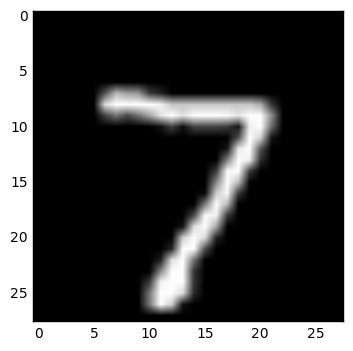

Model Prediction is:  7
The label is:  7


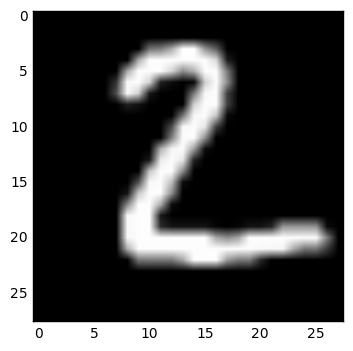

Model Prediction is:  2
The label is:  2


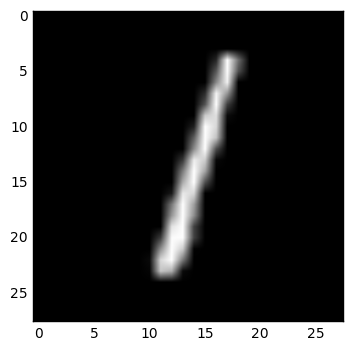

Model Prediction is:  1
The label is:  1


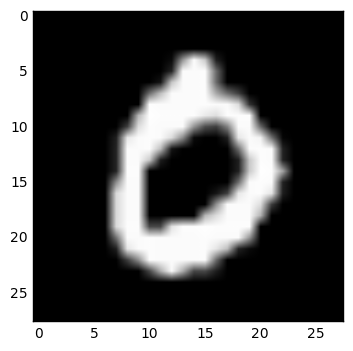

Model Prediction is:  0
The label is:  0


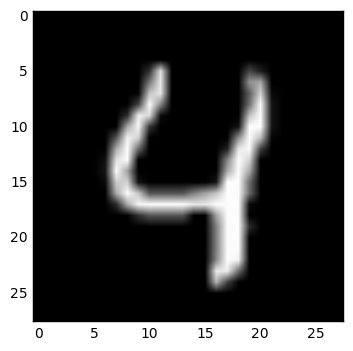

Model Prediction is:  4
The label is:  4


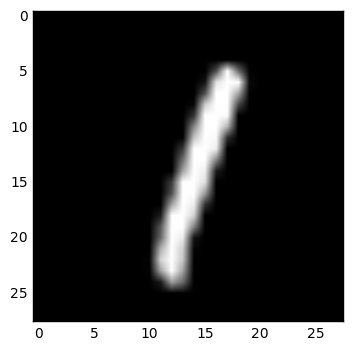

Model Prediction is:  1
The label is:  1


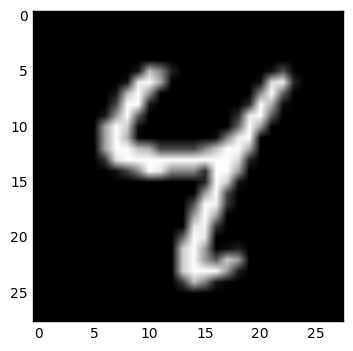

Model Prediction is:  4
The label is:  4


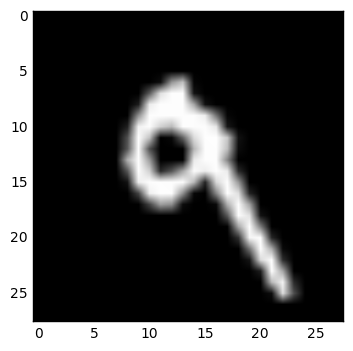

Model Prediction is:  9
The label is:  9


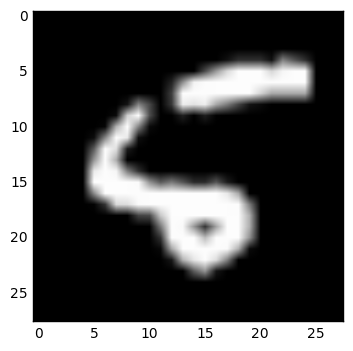

Model Prediction is:  5
The label is:  5


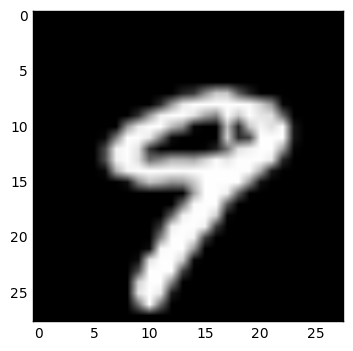

Model Prediction is:  9
The label is:  9


In [43]:
#Predict single images
n_images = 10

#Get images from test set
test_images = mnist.test.images[:n_images]

mnist_not_onehot = input_data.read_data_sets('C:/Users/StrikeWade/Desktop/DLML/Tensorflow Examples Models/mnist', one_hot=False)
test_labels = mnist_not_onehot.test.labels[:n_images]

#Prepare the input data
input_function = tf.estimator.inputs.numpy_input_fn(x={'images': test_images}, shuffle=False)

#Use the model to predict the image class
preds = list(model.predict(input_function))

#Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.show()
    print('Model Prediction is: ', preds[i])
    print('The label is: ', test_labels[i])